In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm

In [9]:
def lorenz(x):
    return np.array([
        sigma * (x[1] - x[0]),
        x[0]*(r - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ])

def jacobian(x):
    return np.array([
        [-sigma, sigma, 0],
        [r - x[2], -1, -x[0]],
        [x[1], x[0], -beta]
    ])


In [10]:
def rk4_step(x, dt):
    k1 = lorenz(x)
    k2 = lorenz(x + 0.5*dt*k1)
    k3 = lorenz(x + 0.5*dt*k2)
    k4 = lorenz(x + dt*k3)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_variation(x, V, dt):
    J1 = jacobian(x)
    k1 = J1.dot(V)

    x2 = x + 0.5*dt*lorenz(x)
    J2 = jacobian(x2)
    k2 = J2.dot(V + 0.5*dt*k1)

    x3 = x + 0.5*dt*lorenz(x2)
    J3 = jacobian(x3)
    k3 = J3.dot(V + 0.5*dt*k2)

    x4 = x + dt*lorenz(x3)
    J4 = jacobian(x4)
    k4 = J4.dot(V + dt*k3)

    return V + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

In [11]:
dt = 0.005
total_time = 120.0
orthonorm_interval = 0.05
transient = 50.0
x0 = np.array([1.0, 1.0, 1.0])
n_steps = int(total_time / dt)
steps_per_orth = int(round(orthonorm_interval / dt))

In [12]:
com = 4
sigma_ = np.linspace(2,36,com)
beta_ = np.linspace(0.05,3.6,com)
Sigma_ , Beta_ = np.meshgrid(sigma_, beta_)
r_ = [28]*int(len(beta_)**2)

In [13]:
if (len(r_) > len(sigma_)) and (len(r_) > len(beta_)):
    sigma_ = sigma_*int((len(r_)/len(sigma_)))
    beta_ = beta_*int((len(r_)/len(beta_)))
elif (len(sigma_) > len(beta_)) and (len(sigma_) > len(r_)):
    r_ = r_*int((len(sigma_)/len(r_)))
    beta_ = beta_*int((len(sigma_)/len(beta_)))
elif (len(beta_) > len(sigma_)) and (len(beta_) > len(r_)):
    r_ = r_*int((len(beta_)/len(r_)))
    sigma_ = sigma_*int((len(beta_)/len(sigma_)))

In [14]:
all_exponents = []
lyap1 = []
lyap2 = []
lyap3 = []
start = tm.time()
for s in range(0,len(Beta_)):
    for p in range(len(Beta_)):
        sigma = Sigma_[s][p]
        beta = Beta_[s][p]
        r = r_[s]

        x = x0.copy()
        V = np.eye(3)
        eps = 1e-12
        sums = np.zeros(3)
        count = 0

        traj = []
        times = []
        t = 0.0
        lyap_running = []
        for step in range(n_steps):
            x = rk4_step(x, dt)
            V = rk4_variation(x, V, dt)
            t += dt

            if step % steps_per_orth == 0:
                Q, R = np.linalg.qr(V)
                d = np.diag(R)
                if any (np.abs(d)) < eps:
                    d = eps
                signs = np.sign(d)
                signs[signs == 0] = 1
                Q *= signs
                R = (R.T * signs).T

                logs = np.log(np.abs(np.diag(R)) + eps)
                if t > transient:
                    sums += logs
                    count += 1
                    lyap_running.append(sums / (count * orthonorm_interval))

                V = Q.copy()

        lyap = sums / (count * orthonorm_interval)
        lyap_sorted = np.sort(lyap)[::-1]

        all_exponents.append(lyap_sorted)
        lyap1.append(lyap_sorted[0])
        lyap2.append(lyap_sorted[1])
        lyap3.append(lyap_sorted[2])

end = tm.time()
print(end-start)



50.487589836120605


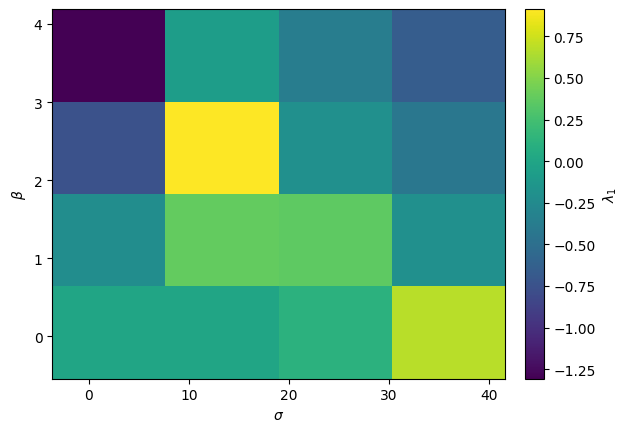

In [15]:

lyap1 = np.array(lyap1)
Lyap1= lyap1.reshape(len(sigma_),len(beta_))

lyap2 = np.array(lyap2)
Lyap2= lyap2.reshape(len(sigma_),len(beta_))

lyap3 = np.array(lyap3)
Lyap3= lyap3.reshape(len(sigma_),len(beta_))

im0 = plt.pcolormesh(Sigma_,Beta_,Lyap1, cmap='viridis', shading='auto', label=r'$\lambda_1$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\beta$')
plt.colorbar(im0 , label=r'$\lambda_1$',fraction=0.046, pad=0.04)
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
Title = [
    r'$\lambda_1$ ',
    r'$\lambda_2$ ',
    r'$\lambda_3$'
]
Colors = ['turbo', 'turbo', 'turbo']
fig, axes = plt.subplots(1,3, figsize=(12,3.5))
for i, (ax,lyap) in enumerate(zip(axes,[Lyap1, Lyap2, Lyap3]), start=1):
    im = axes[i-1].pcolormesh(Sigma_, Beta_, lyap, cmap=Colors[i-1])
    ax.set_title(Title[i-1])
    ax.set_xlabel(r"$\sigma$")
    ax.set_ylabel(r"$\beta$", rotation = 0)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(rf'$\lambda_{i}$',rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
trace = []
trace_lyap =[]
error = []
for k in range (len(sigma_)):
    for j in range (len(beta_)):
        trace.append(-(Sigma_[k][j]+1+Beta_[k][j]))
        error.append(-(Sigma_[k][j]+1+Beta_[k][j])-(Lyap1[k][j]+Lyap3[k][j]+Lyap2[k][j]))
        trace_lyap.append(lyap1[j])
trace = np.array(trace)
error = np.array(error)
error_tot = sum(abs(error))/len(error)
print(error_tot)
Error = error.reshape(len(sigma_),len(beta_))
Trace = trace.reshape(len(sigma_),len(beta_))
im1 = plt.pcolormesh(Sigma_, Beta_, Error, cmap ='turbo',label='Trace of the Jacobian-Matrix')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\beta$')
plt.colorbar(im1 , label=r'Error of $\Sigma \lambda$',fraction=0.046, pad=0.04)
plt.show()

In [ ]:
from matplotlib.cbook import ls_mapper
data = np.column_stack((Lyap1, Lyap2, Lyap3, Sigma_,Beta_ ))
beta1 = Beta_[0][0]
beta2 = Beta_[-1][-1]
sigma1 = Sigma_[0][0]
sigma2 = Sigma_[-1][-1]
ls = len(sigma_)
lb = len(beta_)
with open(f"[{sigma1},{sigma2}]x[{beta1},{beta2}]_with{ls}x{lb}.txt", "w") as f:
    np.savetxt(f, Lyap1, fmt="%.2f", header="Lyap1")
    np.savetxt(f, Lyap2, fmt="%.2f", header="Lyap2")
    np.savetxt(f, Lyap3, fmt="%.2f", header="Lyap3")
    np.savetxt(f, Sigma_, fmt="%.2f", header="Sigma")
    np.savetxt(f, Beta_, fmt="%.2f", header="Beta")